In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

: 

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [3]:
data_dir = pathlib.Path('./data/MIDI/')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))


Number of files: 2055


In [4]:
sample_file = filenames[0]
print(sample_file)

data/MIDI/chords/ashover43.mid


In [5]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [6]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [7]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [8]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [9]:
for i, note in enumerate(instrument.notes[:30]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=36, note_name=C2, duration=3.0000
1: pitch=40, note_name=E2, duration=3.0000
2: pitch=43, note_name=G2, duration=3.0000
3: pitch=41, note_name=F2, duration=3.0000
4: pitch=45, note_name=A2, duration=3.0000
5: pitch=48, note_name=C3, duration=3.0000
6: pitch=43, note_name=G2, duration=3.0000
7: pitch=47, note_name=B2, duration=3.0000
8: pitch=50, note_name=D3, duration=3.0000
9: pitch=36, note_name=C2, duration=3.0000
10: pitch=40, note_name=E2, duration=3.0000
11: pitch=43, note_name=G2, duration=3.0000
12: pitch=36, note_name=C2, duration=3.0000
13: pitch=40, note_name=E2, duration=3.0000
14: pitch=43, note_name=G2, duration=3.0000
15: pitch=41, note_name=F2, duration=3.0000
16: pitch=45, note_name=A2, duration=3.0000
17: pitch=48, note_name=C3, duration=3.0000
18: pitch=43, note_name=G2, duration=3.0000
19: pitch=47, note_name=B2, duration=3.0000
20: pitch=50, note_name=D3, duration=3.0000
21: pitch=36, note_name=C2, duration=3.0000
22: pitch=40, note_name=E2, duration=3.000

In [10]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [11]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,36,0.0,3.0,0.0,3.0
1,40,0.0,3.0,0.0,3.0
2,43,0.0,3.0,0.0,3.0
3,41,3.0,6.0,3.0,3.0
4,45,3.0,6.0,0.0,3.0


In [12]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C2', 'E2', 'G2', 'F2', 'A2', 'C3', 'G2', 'B2', 'D3', 'C2'],
      dtype='<U3')

In [13]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

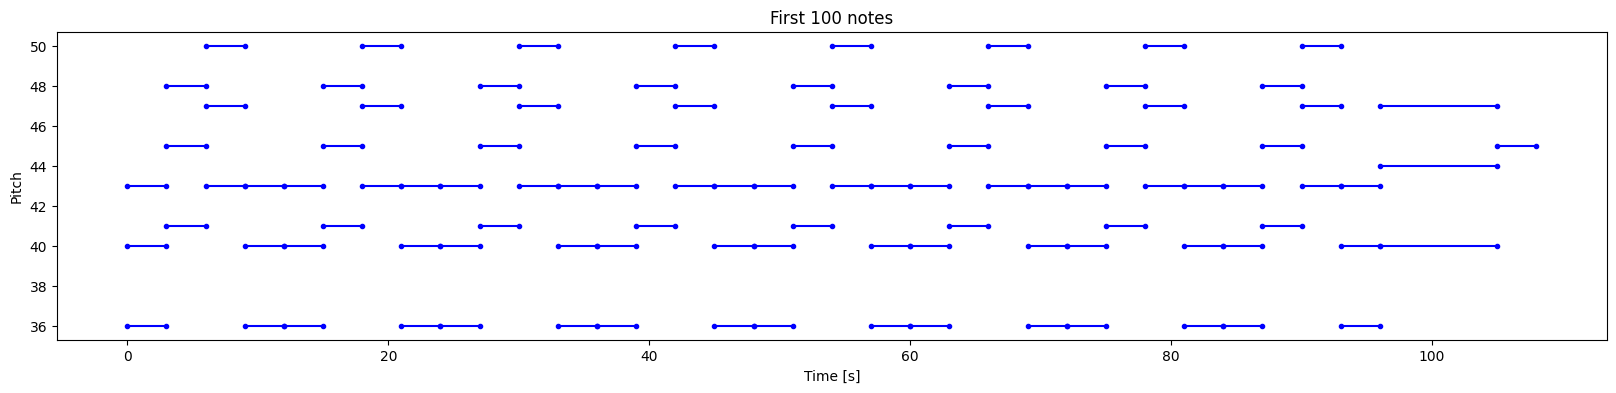

In [14]:
plot_piano_roll(raw_notes, count=100)

In [15]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

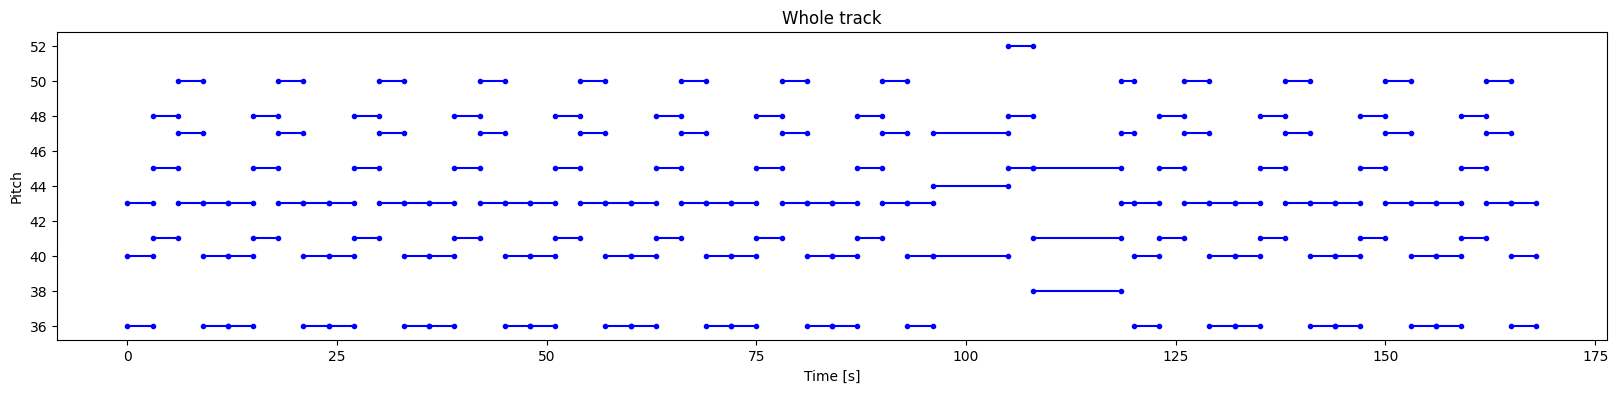

In [16]:
plot_piano_roll(raw_notes)

In [17]:
class MIDI_Dataset:
    def __init__(self, path):
        self.path = path
        self.all_notes = []
        self.num_files = 0

    def read_data(self):
        data_dir = pathlib.Path(self.path)
        filenames = glob.glob(str(data_dir/'**/*.mid*'))
        self.num_files = len(filenames)
        print('Number of files:', self.num_files)
        for f in filenames[:self.num_files]:
            notes = self.midi_to_notes(f)
            self.all_notes.append(notes)
        self.all_notes = pd.concat(self.all_notes)
        n_notes = len(self.all_notes)
        print("Number of notes parsed : ", n_notes)

    def midi_to_notes(self,midi_file):
        pm = pretty_midi.PrettyMIDI(midi_file)
        instrument = pm.instruments[0]
        notes = collections.defaultdict(list)

        # Sort the notes by start time
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
        prev_start = sorted_notes[0].start

        for note in sorted_notes:
            start = note.start
            end = note.end
            notes['pitch'].append(note.pitch)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)
            notes['filename'].append(midi_file)
            prev_start = start
        return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [18]:
dataset = MIDI_Dataset('./data/MIDI')
dataset.read_data()
print(dataset.all_notes.head())

Number of files: 2055
Number of notes parsed :  356263
   pitch  start  end  step  duration                        filename
0     36    0.0  3.0   0.0       3.0  data/MIDI/chords/ashover43.mid
1     40    0.0  3.0   0.0       3.0  data/MIDI/chords/ashover43.mid
2     43    0.0  3.0   0.0       3.0  data/MIDI/chords/ashover43.mid
3     41    3.0  6.0   3.0       3.0  data/MIDI/chords/ashover43.mid
4     45    3.0  6.0   0.0       3.0  data/MIDI/chords/ashover43.mid


In [19]:
n_notes = len(dataset.all_notes)

In [20]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([dataset.all_notes[key] for key in key_order], axis=1)

In [21]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2023-11-11 19:33:58.918211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46702 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1d:00.0, compute capability: 8.6
2023-11-11 19:33:58.920016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46702 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:20:00.0, compute capability: 8.6
2023-11-11 19:33:58.922208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46702 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6
2023-11-11 19:33:58.924318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46702 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:22:00.0, 

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [22]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [24]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.28125   0.        3.       ]
 [0.3125    0.        3.       ]
 [0.3359375 0.        3.       ]
 [0.3203125 3.        3.       ]
 [0.3515625 0.        3.       ]
 [0.375     0.        3.       ]
 [0.3359375 3.        3.       ]
 [0.3671875 0.        3.       ]
 [0.390625  0.        3.       ]
 [0.28125   3.        3.       ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=40.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=3.0>}


In [25]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [26]:
midi_data = pretty_midi.PrettyMIDI("./data/MIDI/ashover9.mid")
piano_roll = midi_data.get_piano_roll()
print(np.sum(piano_roll))

4347000.0


/users/ug21/atishay/.local/lib/python3.9/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [27]:
piano_roll.shape

(128, 9600)

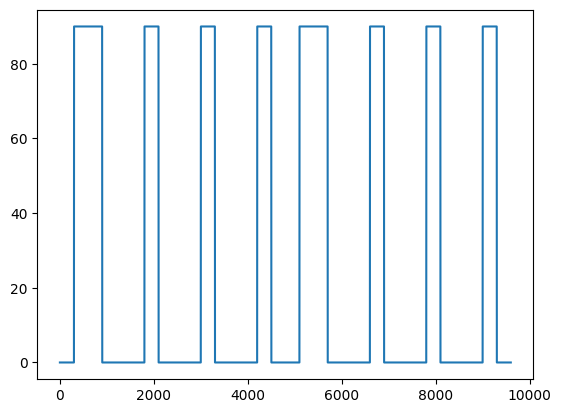

In [28]:
plt.plot(piano_roll[45])

In [29]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [30]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [31]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [32]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2023-11-11 19:34:12.261238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 153896 of 356238
2023-11-11 19:34:26.447803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-11 19:34:27.733101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


5566/5566 [==============================] - 58s 6ms/step - loss: 8.9082 - duration_loss: 3.3795 - pitch_loss: 4.8608 - step_loss: 0.6680


2023-11-11 19:34:59.802800: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13666802901175017428
2023-11-11 19:34:59.802904: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1543846336317331224


{'loss': 8.908207893371582,
 'duration_loss': 3.379460573196411,
 'pitch_loss': 4.860783576965332,
 'step_loss': 0.667983889579773}

In [33]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [34]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  5


In [35]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


2023-11-11 19:35:01.314838: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x48dc8300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-11 19:35:01.314904: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-11 19:35:01.314920: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-11 19:35:01.314931: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-11 19:35:01.314941: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-11 19:35:01.314952: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-11 19:35:01.330675: I tensorflow/compiler/mlir/tensorflow/utils

5566/5566 [==============================] - 52s 9ms/step - loss: 2.4403 - duration_loss: 0.1478 - pitch_loss: 2.2018 - step_loss: 0.0907
Epoch 2/50
   7/5566 [..............................] - ETA: 48s - loss: 2.0623 - duration_loss: 0.0855 - pitch_loss: 1.9066 - step_loss: 0.0702

2023-11-11 19:35:51.537703: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5039969094980327672
2023-11-11 19:35:51.537779: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13666802901175017428
2023-11-11 19:35:51.537800: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2841509236337423854
2023-11-11 19:35:51.537843: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1543846336317331224


5566/5566 [==============================] - 48s 9ms/step - loss: 1.9194 - duration_loss: 0.1288 - pitch_loss: 1.7286 - step_loss: 0.0621
Epoch 3/50
5566/5566 [==============================] - 49s 9ms/step - loss: 1.7799 - duration_loss: 0.1238 - pitch_loss: 1.5996 - step_loss: 0.0565
Epoch 4/50
5566/5566 [==============================] - 49s 9ms/step - loss: 1.7182 - duration_loss: 0.1196 - pitch_loss: 1.5461 - step_loss: 0.0525
Epoch 5/50
5566/5566 [==============================] - 49s 9ms/step - loss: 1.6805 - duration_loss: 0.1180 - pitch_loss: 1.5116 - step_loss: 0.0509
Epoch 6/50
5566/5566 [==============================] - 49s 9ms/step - loss: 1.6480 - duration_loss: 0.1159 - pitch_loss: 1.4822 - step_loss: 0.0499
Epoch 7/50
5566/5566 [==============================] - 49s 9ms/step - loss: 1.6189 - duration_loss: 0.1104 - pitch_loss: 1.4592 - step_loss: 0.0494
Epoch 8/50
5566/5566 [==============================] - 49s 9ms/step - loss: 1.6126 - duration_loss: 0.1072 - pitch_l